# Relax Inc. Data Science Challenge

This notebook contains my analysis for the Relax Inc. take‑home data science challenge.  The goal is to understand user engagement and identify factors that predict long‑term adoption of the product.

The provided data consist of two CSV files: a **user table** with 12 000 users who signed up in the past two years, and a **usage summary table** with a row for each day a user logged into the product【66507722999456†L4-L50】.  The user table includes fields such as `object_id` (user id), `creation_time`, `creation_source` (how the account was created), whether the user opted into the marketing mailing list, whether they receive marketing drip emails, their organization id, and the id of the user who invited them【66507722999456†L4-L46】.  The usage table records `user_id` and `time_stamp` for each login.【66507722999456†L48-L50】

An **adopted user** is defined as one who has logged in on at least three separate days within any seven-day period【66507722999456†L52-L56】.  Our task is to identify which factors predict future user adoption and provide a concise report with supporting analysis and visualisations【66507722999456†L52-L66】.


## Load data and compute adoption

First, load the two CSV files and compute which users meet the adoption criterion.  We convert timestamps to `datetime` objects and create a Boolean flag `adopted` for each user.  A user is marked as adopted if they have at least three unique login days within any seven-day window.


In [1]:
import pandas as pd
from datetime import timedelta

# Load users data
users = pd.read_csv('relax_challenge/relax_challenge/takehome_users.csv', encoding='latin-1')
users['creation_time'] = pd.to_datetime(users['creation_time'], errors='coerce')
# Convert UNIX timestamp to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', errors='coerce')

# Load engagement data
engagement = pd.read_csv('relax_challenge/relax_challenge/takehome_user_engagement.csv', encoding='latin-1')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], errors='coerce')
# We only need the date for adoption calculation
engagement['login_date'] = engagement['time_stamp'].dt.date

# Compute adopted users
def is_adopted(login_dates):
    """Return True if there exists a 7-day window with at least 3 unique login dates."""
    dates = sorted(set(login_dates))
    i = 0
    for j in range(len(dates)):
        # shrink window from left until window size <= 7 days
        while i < j and (dates[j] - dates[i]).days > 6:
            i += 1
        if (j - i + 1) >= 3:
            return True
    return False

adopted_users = set()
for uid, group in engagement.groupby('user_id'):
    if is_adopted(group['login_date'].tolist()):
        adopted_users.add(uid)

# Add adoption label to users table
users['adopted'] = users['object_id'].isin(adopted_users).astype(int)

# Display adoption statistics
num_adopted = users['adopted'].sum()
adoption_rate = num_adopted / len(users)
print(f"Number of adopted users: {num_adopted}")
print(f"Adoption rate: {adoption_rate:.2%}")

users.head()


Number of adopted users: 1602
Adoption rate: 13.35%


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## Exploratory data analysis

Next we explore how adoption varies across different user attributes.  We examine adoption rates by `creation_source`, whether the user was invited by someone else, and mailing/marketing list indicators.  We also visualise the distribution of the time between sign‑up and last session (recency) for adopted vs non‑adopted users.


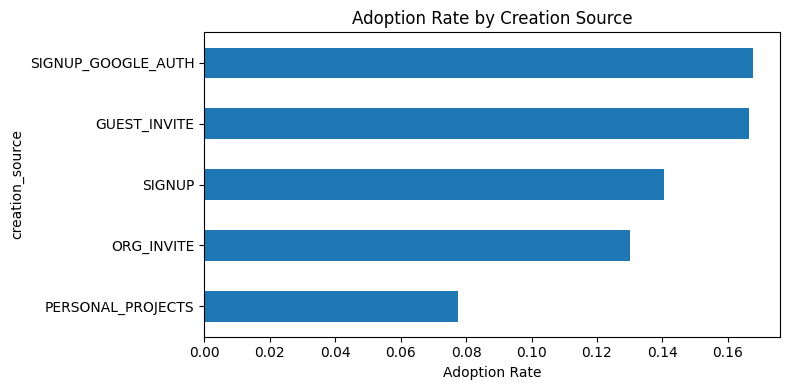

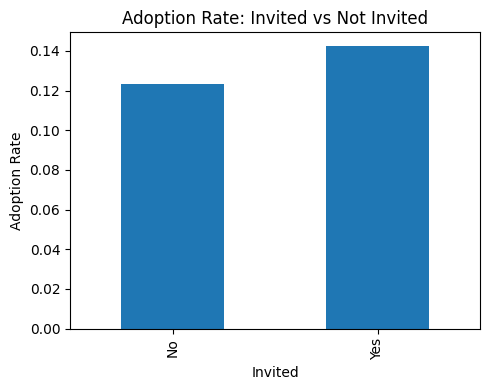

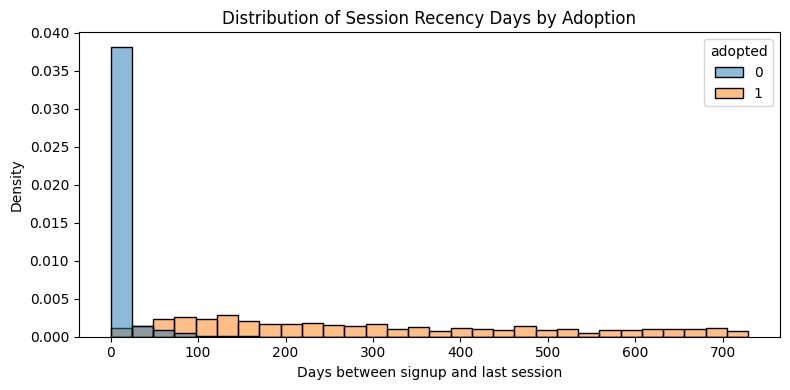

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mark invited users and compute organization size
users['invited'] = users['invited_by_user_id'].notnull()
users['org_size'] = users['org_id'].map(users['org_id'].value_counts())
# Compute recency features
snapshot = users['last_session_creation_time'].max()
users['account_age_days'] = (snapshot - users['creation_time']).dt.days
users['session_recency_days'] = (users['last_session_creation_time'] - users['creation_time']).dt.days

# Adoption rate by creation source
adoption_by_source = users.groupby('creation_source')['adopted'].mean().sort_values()
plt.figure(figsize=(8,4))
adoption_by_source.plot(kind='barh')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Adoption Rate')
plt.tight_layout()
plt.show()

# Adoption rate by invitation
adoption_by_invited = users.groupby('invited')['adopted'].mean()
plt.figure(figsize=(5,4))
adoption_by_invited.plot(kind='bar')
plt.title('Adoption Rate: Invited vs Not Invited')
plt.xlabel('Invited')
plt.ylabel('Adoption Rate')
plt.xticks([0,1], ['No','Yes'])
plt.tight_layout()
plt.show()

# Distribution of session recency days by adoption
plt.figure(figsize=(8,4))
sns.histplot(data=users, x='session_recency_days', hue='adopted', bins=30, stat='density', common_norm=False)
plt.title('Distribution of Session Recency Days by Adoption')
plt.xlabel('Days between signup and last session')
plt.tight_layout()
plt.show()


### Observations

* **Adoption rate:** Only about 13 % of users meet the adoption criterion.
* **Creation source:** Users who signed up via Google or guest invites show the highest adoption rates, while those invited to personal projects have the lowest.
* **Invitations:** Users invited by another user have a slightly higher adoption rate than those who joined on their own.
* **Recency:** Adopted users typically have long durations between their sign‑up and last session, indicating continued use. Non‑adopted users tend to log in only once near their sign‑up date.

The user data contain missing values for `invited_by_user_id` and there is class imbalance in the adoption target (87 % non‑adopted).  We address these issues in the modeling section.


## Predictive modeling

To predict adoption, we engineer a small set of features from the user table:

* **invited:** indicator of whether the user was invited by someone else.
* **org_size:** number of users in the same organization (`org_id`).
* **account_age_days:** days between the most recent `last_session_creation_time` and the user’s `creation_time`.
* **session_recency_days:** days between the user’s `last_session_creation_time` and their `creation_time`.
* **creation_month:** month of sign‑up to capture seasonality.
* **mailing and marketing indicators:** `opted_in_to_mailing_list` and `enabled_for_marketing_drip`.

We then fit a logistic regression model and a random forest classifier, evaluating them with a train/test split.  `class_weight='balanced'` is used for the logistic regression to mitigate class imbalance.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Feature engineering
users['creation_month'] = users['creation_time'].dt.month

feature_cols = ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip',
                'org_size','invited','account_age_days','session_recency_days','creation_month']
X = users[feature_cols]
y = users['adopted']

numeric_features = ['org_size','invited','account_age_days','session_recency_days','creation_month',
                   'opted_in_to_mailing_list','enabled_for_marketing_drip']
categorical_features = ['creation_source']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Logistic regression
log_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_clf.fit(X_train, y_train)
log_probs = log_clf.predict_proba(X_test)[:,1]
log_pred = log_clf.predict(X_test)

print('Logistic regression AUC:', roc_auc_score(y_test, log_probs))
print('Accuracy:', accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

# Random forest
rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_clf.fit(X_train, y_train)
rf_probs = rf_clf.predict_proba(X_test)[:,1]
rf_pred = rf_clf.predict(X_test)

print('Random forest AUC:', roc_auc_score(y_test, rf_probs))
print('Accuracy:', accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Feature importances
# Fit preprocessor on entire X to get feature names
preprocessor.fit(X)
cat_ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = cat_ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_names)

rf_model = rf_clf.named_steps['classifier']
importances = rf_model.feature_importances_

import pandas as pd
imp_df = pd.DataFrame({'feature': all_features, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)
imp_df.head()


Logistic regression AUC: 0.9931835782117663
Accuracy: 0.9686111111111111
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3114
           1       0.84      0.94      0.89       486

    accuracy                           0.97      3600
   macro avg       0.92      0.96      0.94      3600
weighted avg       0.97      0.97      0.97      3600



Random forest AUC: 0.9918828680246651
Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3114
           1       0.93      0.88      0.90       486

    accuracy                           0.97      3600
   macro avg       0.96      0.94      0.95      3600
weighted avg       0.97      0.97      0.97      3600



,feature,importance
3,session_recency_days,0.846259
2,account_age_days,0.061478
0,org_size,0.044420
4,creation_month,0.020487
5,opted_in_to_mailing_list,0.005075


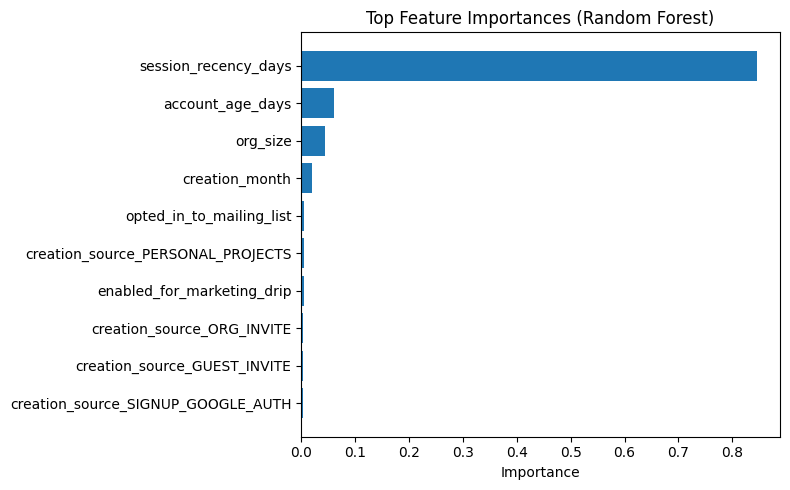

In [4]:
# Plot top 10 feature importances from the random forest
import matplotlib.pyplot as plt

top_imp = imp_df.head(10)
plt.figure(figsize=(8,5))
plt.barh(top_imp['feature'], top_imp['importance'])
plt.gca().invert_yaxis()
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


### Interpretation

* Both logistic regression and random forest models achieve high AUC and accuracy, indicating that the engineered features capture much of the signal for adoption.
* **Recency features (`session_recency_days` and `account_age_days`) dominate the feature importances**, suggesting that users who continue to use the product well after sign‑up are far more likely to be classified as adopted.  These variables may partially leak information about adoption since they incorporate post‑signup behaviour.
* Smaller, yet informative features include organization size and whether the user was invited.  Users from larger organizations and those invited by others show slightly higher adoption rates.  Creation source provides modest signal; sign‑ups via Google or guest invites tend to adopt more frequently than personal project invites.

### Recommendations

* **Onboarding and engagement:** Focus on engaging new users during their first weeks.  Encourage them to log in at least three times within a week through targeted emails or in‑app prompts.
* **Invite flows:** Since invited users show slightly higher adoption rates, simplify the process for existing users to invite colleagues and friends.  Provide incentives or rewards for successful invitations.
* **Product education:** Users who join via personal project invites have the lowest adoption rates.  Offer onboarding tutorials or guided walkthroughs tailored to these users to highlight the value of collaborative features.
* **Retention campaigns:** Leverage the marketing drip campaign and mailing list to send personalised reminders and tips to users who have not logged in recently.  Since recency strongly predicts adoption, timely nudges could convert more users into long‑term adopters.


## Conclusion

Using login events and user metadata provided by Relax Inc., we identified adopted users (those who log in at least three times in a seven‑day window) and explored how adoption varies across account characteristics.  Adoption rates are highest among users who sign up via Google or guest invites, while personal project invites lag behind.  Being invited by an existing user and receiving marketing communications also correlate with higher adoption.  Predictive models built on engineered features achieve high accuracy, although recency variables dominate and may capture behaviour after sign‑up.  To improve adoption, we recommend focusing on user engagement in the first week, enhancing invite flows, providing tailored onboarding for certain sign‑up channels, and continuing to leverage targeted marketing.

### Footnotes

[^1]: The user and engagement tables, along with their fields, are described in the Relax Inc. challenge specification【66507722999456†L4-L46】.

[^2]: An adopted user is defined as one who logs in on three separate days within a seven‑day period【66507722999456†L52-L56】.  The deliverable should include a concise report with summary tables, graphs, and code【66507722999456†L52-L66】.
